In [7]:
import pandas as pd
import numpy as np, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load Data

In [8]:
folder_path = u'C:/Users/user/Desktop/AI-project/features/128' 

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_128.csv')]

# Initialize an empty DataFrame to concatenate all data
all_data = pd.DataFrame()
all_data_list = []
# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now 'all_data_list' contains a list of all data from all CSV files

In [9]:
folder_path = u'C:/Users/user/Desktop/AI-project/features/250' 

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_250.csv')]

# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now 'all_data_list' contains a list of all data from all CSV files

# Label mapping

In [10]:
#Sobstitute N, S, V with 0, 1, 2
label_mapping = {'N': 0, 'S': 1, 'V': 2}
for data in all_data_list:
    data['annotation'] = data['annotation'].replace(label_mapping)

# Divide train/test

In [11]:
# Split Data
#A list of all csv is gived: because each element of a list represent a patient,
# a patient will stay only or in train or in test
train_list, test_list = train_test_split(all_data_list, test_size=0.2, random_state=42)
#train_list, val_list = train_test_split(train_list, test_size=0.2, random_state=42)

In [12]:
#Create a dataframe only for train and one for all test data
train_data = pd.DataFrame()
i = 0
for train in train_list:
    train_data = pd.concat([train_data, train], ignore_index=True)
    i = i + 1

In [13]:
# Model Training
X_train = train_data.drop('annotation', axis=1)
y_train = train_data['annotation']

In [14]:
# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_train, columns=['annotation'])

one_hot_encoded_array_train = one_hot_encoded_df.values

print(one_hot_encoded_df)
print(one_hot_encoded_array_train)

           0      1      2
0       True  False  False
1       True  False  False
2       True  False  False
3       True  False  False
4       True  False  False
...      ...    ...    ...
137339  True  False  False
137340  True  False  False
137341  True  False  False
137342  True  False  False
137343  True  False  False

[137344 rows x 3 columns]
[[ True False False]
 [ True False False]
 [ True False False]
 ...
 [ True False False]
 [ True False False]
 [ True False False]]


In [15]:
#Create a dataframe only for train and one for all test data
'''
val_data = pd.DataFrame()

for val in val_list:
    val_data = pd.concat([val_data, val], ignore_index=True) '''

'\nval_data = pd.DataFrame()\n\nfor val in val_list:\n    val_data = pd.concat([val_data, val], ignore_index=True) '

In [16]:
'''X_val = val_data.drop('annotation', axis=1)
y_val = val_data['annotation'] '''

"X_val = val_data.drop('annotation', axis=1)\ny_val = val_data['annotation'] "

In [17]:
'''one_hot_encoded_df_val = pd.get_dummies(y_val, columns=['annotation'])

one_hot_encoded_array_val = one_hot_encoded_df_val.values '''

"one_hot_encoded_df_val = pd.get_dummies(y_val, columns=['annotation'])\n\none_hot_encoded_array_val = one_hot_encoded_df_val.values "

In [18]:
test_data = pd.DataFrame()

for test in test_list:
    test_data = pd.concat([test_data, test], ignore_index=True)

In [19]:
X_test = test_data.drop('annotation', axis=1)
y_test= test_data['annotation']

In [20]:
one_hot_encoded_df_test = pd.get_dummies(y_test, columns=['annotation'])

one_hot_encoded_array_test = one_hot_encoded_df_test.values

In [21]:
N_train = (y_train == 0).sum() 
S_train = (y_train == 1).sum() 
V_train = (y_train == 2).sum() 
'''
N_val = (y_val == 0).sum() 
S_val = (y_val == 1).sum() 
V_val = (y_val == 2).sum() 

'''
N_test = (y_test == 0).sum() 
S_test = (y_test == 1).sum() 
V_test = (y_test == 2).sum() 

N_perc = N_train/(N_train+S_train+V_train)
S_perc = S_train/(N_train+S_train+V_train)
V_perc = V_train/(N_train+S_train+V_train)
print(f"Perc di N in train: {N_perc}")
print(f"Perc di S in train: {S_perc}")
print(f"Perc di V in train: {V_perc}")
'''
N_perc = N_val/(N_val+S_val+V_val)
S_perc = S_val/(N_val+S_val+V_val)
V_perc = V_val/(N_val+S_val+V_val)

print(f"Perc di S in val: {N_perc}")
print(f"Perc di S in val: {S_perc}")
print(f"Perc di S in val: {V_perc}")
'''
N_perc = N_test/(N_test+S_test+V_test)
S_perc = S_test/(N_test+S_test+V_test)
V_perc = V_test/(N_test+S_test+V_test)
print(f"Perc di S in test: {N_perc}")
print(f"Perc di S in test: {S_perc}")
print(f"Perc di S in test: {V_perc}")


Perc di N in train: 0.9240884203168686
Perc di S in train: 0.04832391658900279
Perc di V in train: 0.027587663094128613
Perc di S in test: 0.9049530732924645
Perc di S in test: 0.03013616882764607
Perc di S in test: 0.06491075787988933


# Model

In [22]:
def compute_class_freqs(labels):

    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [23]:
freq_pos, freq_neg = compute_class_freqs(one_hot_encoded_array_train)

print(f"pos freqs: {freq_pos}")

print(f"neg freqs: {freq_neg}")

pos freqs: [0.92408842 0.04832392 0.02758766]
neg freqs: [0.07591158 0.95167608 0.97241234]


In [24]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

keys = np.arange(0,3,1)
weight_dictionary_freq = dict(zip(keys, pos_weights))
weight_dictionary_freq

{0: 0.07591157968313145, 1: 0.9516760834109972, 2: 0.9724123369058714}

In [25]:
#@title Calculating Weights
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true):
    num_classes = y_true.shape[1]
    weights = np.empty([num_classes, 2])
    for i in range(num_classes):
        weights[i] = compute_class_weight(class_weight='balanced', classes=[0.,1.], y=y_true[:, i])
    return weights

class_weights = calculating_class_weights(one_hot_encoded_array_train)

keys = np.arange(0,3,1)
weight_dictionary_fold = dict(zip(keys, class_weights.T[1]))
weight_dictionary_fold

{0: 0.5410737641626877, 1: 10.346843453367486, 2: 18.124043283188175}

In [26]:
def model_evaluation(y_predi, model_name_pred):

    predicted_class = np.argmax(y_predi, axis=-1)
    test_classes = np.argmax(one_hot_encoded_array_test, axis=-1)
    cm = confusion_matrix(test_classes, predicted_class)
    classes_name = ['N', 'S', 'V']
    '''
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True, fmt='.2f')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.show()
    '''
    
    #Normalized cm
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True, fmt='.2f')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.title(model_name_pred)
    plt.show()

# AdaBoost

In [27]:
from imblearn.ensemble import EasyEnsembleClassifier

modelEasyEns = EasyEnsembleClassifier(n_estimators=100, n_jobs=-1, random_state=42)
modelEasyEns.fit(X_train, y_train)

y_predEasyEns = modelEasyEns.predict(X_test)

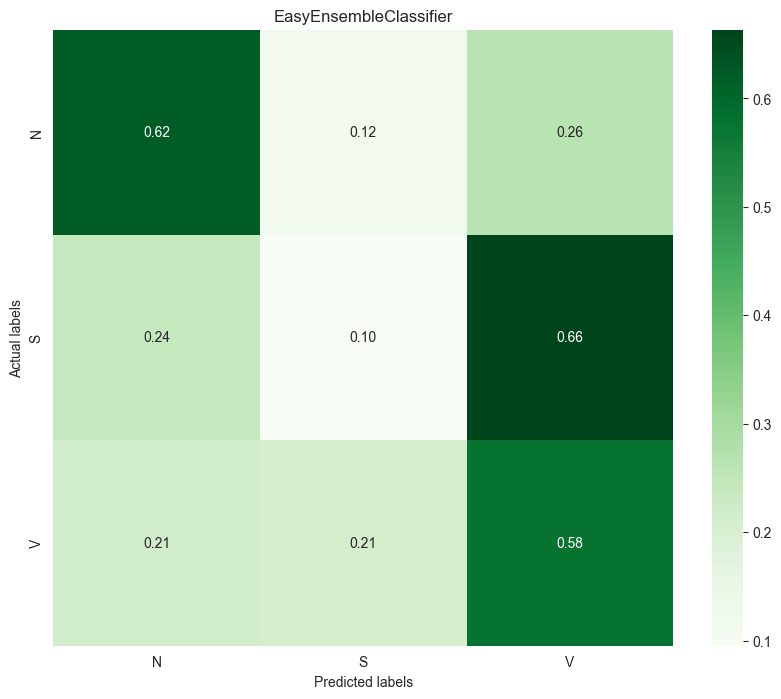

In [28]:
one_hot_encoded_pred_ens = pd.get_dummies(y_predEasyEns, columns=['0'])

model_evaluation(one_hot_encoded_pred_ens, "EasyEnsembleClassifier")

# Random Forest

In [29]:
'''from sklearn.model_selection import GridSearchCV

parameter_grid = { 
    'n_estimators': [50, 100],
    'max_features': [None, 'sqrt', 'log2', 3],
    'max_depth' : [10, 15],
    'criterion' :['gini', 'entropy'],
    'min_samples_split' : [22, 42]
}
my_model = RandomForestClassifier()
clf = GridSearchCV(my_model, parameter_grid, cv = 5, scoring = 'f1', n_jobs = -1, verbose = 1)
clf.fit(X_train, y_train)
from sklearn import metrics
print(clf.best_params_)
print(clf.best_score_)
'''

"from sklearn.model_selection import GridSearchCV\n\nparameter_grid = { \n    'n_estimators': [50, 100],\n    'max_features': [None, 'sqrt', 'log2', 3],\n    'max_depth' : [10, 15],\n    'criterion' :['gini', 'entropy'],\n    'min_samples_split' : [22, 42]\n}\nmy_model = RandomForestClassifier()\nclf = GridSearchCV(my_model, parameter_grid, cv = 5, scoring = 'f1', n_jobs = -1, verbose = 1)\nclf.fit(X_train, y_train)\nfrom sklearn import metrics\nprint(clf.best_params_)\nprint(clf.best_score_)\n"

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomForestModel = RandomForestClassifier(n_estimators=100, 
                                              criterion='gini', 
                                              class_weight='balanced' )
randomForestModel.fit(X_train, y_train)

y_predRanFor = randomForestModel.predict(X_test)

In [ ]:
one_hot_encoded_pred = pd.get_dummies(y_predRanFor, columns=['0'])

model_evaluation(one_hot_encoded_pred, "Random forest weighted")

In [ ]:
nN = np.count_nonzero(y_train == 0)
nV = np.count_nonzero(y_train == 1)
nS = np.count_nonzero(y_train == 2)

class_sum = nN+nV+nS
wN = round(1-(nN/class_sum),2)
wV = round(1-(nV/class_sum),2)  
wS = round(1-(nS/class_sum),2)

class_weights = {0: wN+0.42, 1: wV+0.03, 2: wS+0.02}

print(class_weights)

# Balanced Random Forest

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
randomForestModel = BalancedRandomForestClassifier(n_estimators= 100,
                                                   criterion= 'gini',
                                                   max_depth= 20,
                                                   min_samples_split= 30,
                                                   min_samples_leaf = 1,
                                                   min_weight_fraction_leaf = 0.0,
                                                   max_features= None,
                                                   sampling_strategy='not minority',
                                                   replacement= False,
                                                   n_jobs= -1,
                                                   random_state=42,
                                                   class_weight= class_weights,
                                                   bootstrap=True
                                                   )
randomForestModel.fit(X_train, 
              y_train)
y_pred = randomForestModel.predict(X_test)
one_hot_encoded_pred = pd.get_dummies(y_pred, columns=['0'])

model_evaluation(one_hot_encoded_pred, "Random forest balanced")

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kneig  = KNeighborsClassifier(n_neighbors=10)

kneig.fit(X_train, 
              y_train)
y_pred = kneig.predict(X_test)
one_hot_encoded_pred = pd.get_dummies(y_pred, columns=['0'])

model_evaluation(one_hot_encoded_pred, "kneig")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
# Models
models = {
   #'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest 2': RandomForestClassifier(n_estimators=100, 
                                              criterion='gini', 
                                              max_depth=15 ,
                                              min_samples_split=22, 
                                              #class_weight=[{0: 0.5779660434423975, 1: 6.675863437872171, 2: 8.333250743310208}] 
                                              ),
    'Balanced Random Forest': BalancedRandomForestClassifier(n_estimators=100, class_weight={0: 0.5779660434423975, 1: 6.675863437872171, 2: 8.333250743310208}),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Train and evaluate each model

for model_name, model in models.items():
    model.fit(X_train, 
              one_hot_encoded_array_train)
    y_pred = model.predict(X_test)
    model_evaluation(y_pred, model_name)
    